In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Assignment: A03
### Neural Network with :
- One hidden layer 
- ${Tanh}$ activation function


### Assignment
- **Q1**: Is this model more accurate compared to previous model?
- **Q2**: Prepare table by changing number of neurons in hidden layer, learning rate and observe change in results. Also comment on your results.

|#|Dimension of hidden layer|Learning rate|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:-:|:--|
|1|4|0.1|0.97|0.96|Base case||1|4|0.1|0.97|0.96|Base case|
|2|1|1|???|???|???|
|...|...|...|...|...|...|
|n|...|...|...|...|...|

- **Q3**: What lines will you change to convert it into multi-class prediction model?
- **Q4**: How many epochs are sufficient?

In [4]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [5]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 20000  # number of epochs
ALPHA = 1 # learning rate
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [10]:
def fn_plot_decision_boundary(predict, X, y):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5));
    
    # Small increment to create object function surface
    dm = 0.01
    
    # Range of X values (First feature)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Range of Y values (Second feature)
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # flatten and stack
    # arrays will be stacked along their last axis after being upgraded to at least 2-D 
    # with 1’s post-pended to the shape (column vectors made out of 1-D arrays)
    XX = np.c_[xx.ravel(), yy.ravel()]

    # list to collect predictions
    Z = predict(XX)

    Z = Z.reshape(xx.shape)

    # add another column filled with 1 to make it work with the predict function
    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
    
    # list to collect predictions
    y_pred = []
    
    # Iterate over rows
    # for row in (XX):

    #     # a = predict(row, wts) # this is a float between [0, 1]

    #     y_p = predict(row, wts)
    #     pred = 0
    #     if y_p>0.5:
    #         pred=1
    #     y_pred.append(pred)
        
    # Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

In [12]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, noise=NOISE, shuffle=True, random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

In [14]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [18]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


<Axes: xlabel='target'>

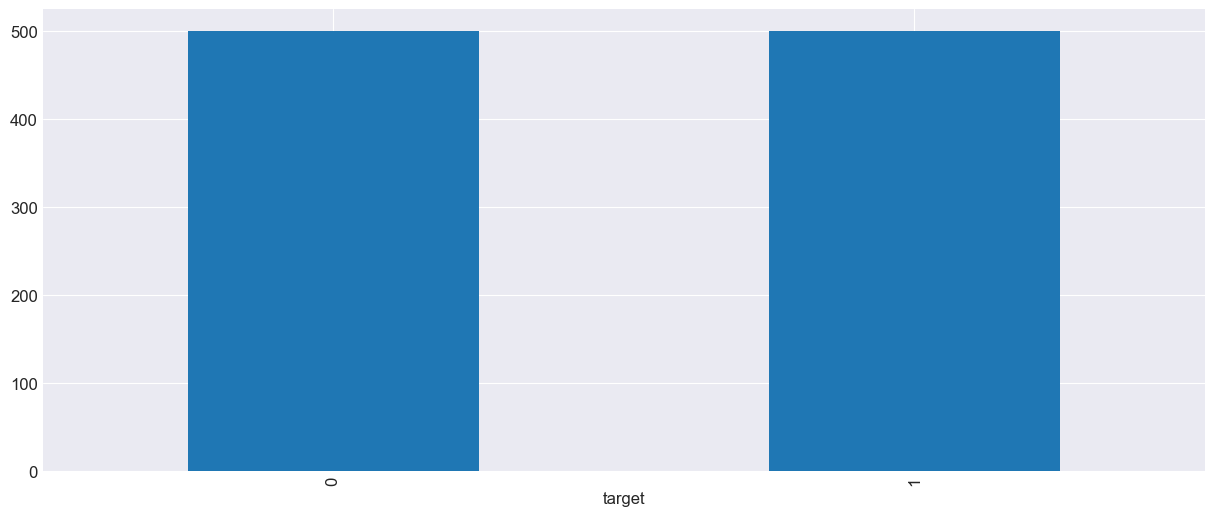

In [20]:
data_df['target'].value_counts().plot(kind='bar')

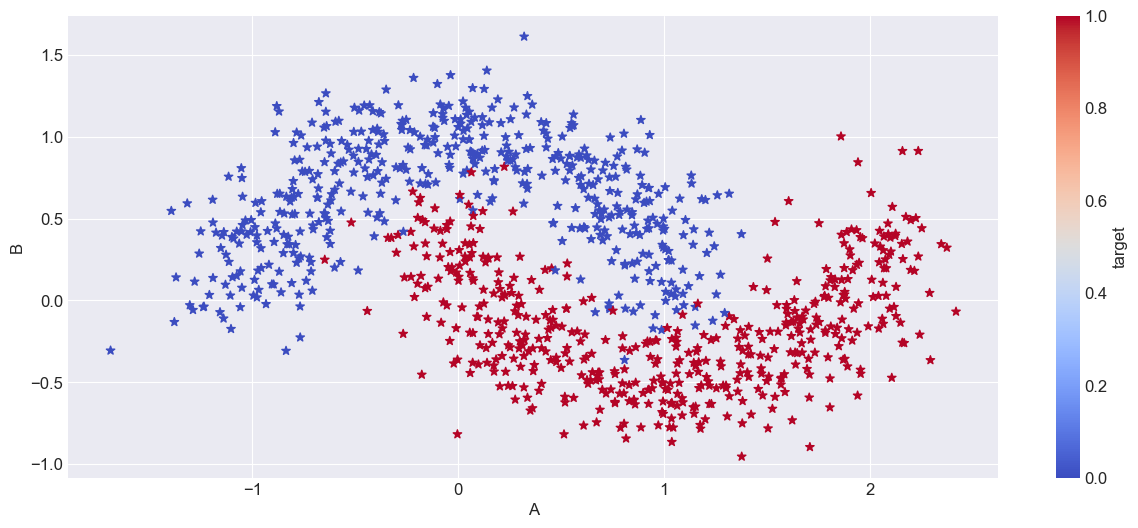

In [22]:
# Plot the data
data_df.plot.scatter('A', 'B',      # columns to plot
                     s = 40,        # size of the marker
                     marker = '*',  # type of marker
                     c = 'target',  # color as per target column
                     cmap=CMAP);    # using colormap

In [24]:
TEST_SIZE = 0.2
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,stratify=y,random_state=RANDOM_STATE )

In [46]:
def fn_sigmoid(z):
    sig_z = 1.0 / (1 + np.exp(-z))
    return sig_z

In [48]:
fn_sigmoid(np.array([[-1., 0., 1.0],[-np.inf, 0, np.inf]]))

array([[0.26894142, 0.5       , 0.73105858],
       [0.        , 0.5       , 1.        ]])

In [50]:
def fn_actv(z):
    return np.tanh(z)

def fn_actv_prime(a):
    return 1.0 - np.tanh(a)**2

In [52]:
fn_actv(np.array([[-1., 0., 1.0],[-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [54]:
np.tanh(0.5)

0.46211715726000974

In [56]:
1-np.tanh(-1)**2

0.41997434161402614

In [58]:
def predict(model, X):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    ### forward propagation
    z1 = X.dot(W1) + b1 # layer 1, Aggregation function
    a1 = fn_actv(z1) # Activations

    z2 = a1.dot(W2) + b2 # layer 2, Aggregation function
    a2 = fn_sigmoid(z2) # Activations

    
    return a2 >= 0.5 # will return true/false 

In [60]:
def calculate_loss(model, X_l, y_l):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    m = X_l.shape[0]
    ### forward propagation
    z1 = X_l.dot(W1) + b1 # layer 1, Aggregation function
    a1 = fn_actv(z1) # Activations

    z2 = a1.dot(W2) + b2 # layer 2, Aggregation function
    a2 = fn_sigmoid(z2) # Activations

    data_loss = -(y_l*np.log(a2)).sum()
    return data_loss/m

In [62]:
def build_model(nn_hdim, X_t, y_t, alpha=ALPHA, epochs=EPOCHS):
    """
    Args:
        nn_hdim: int: number of nodes in hidden layer
        X_t: np.array: train features
        y_t: np.array: train labels
        alpha: float: learning rate
        epochs: int: number of epochs to train
    Return:
        model: dict
    """
    m, nn_input_dim = X_t.shape
    nn_output_dim = y_t.shape[1]

    W1= np.random.rand(nn_input_dim, nn_hdim)/ np.sqrt(nn_input_dim)
    W2= np.random.rand(nn_hdim, nn_output_dim)/ np.sqrt(nn_hdim)

    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    model = {'W1':W1,
            'b1':b1,
            'W2':W2,
            'b2':b2}

    curr_loss = 0
    loss = []
    epoch = []

    for i in range(epochs):
        ### forward propagation
        z1 = X_t.dot(W1) + b1 # layer 1, Aggregation function
        a1 = fn_actv(z1) # Activations
    
        z2 = a1.dot(W2) + b2 # layer 2, Aggregation function
        a2 = fn_sigmoid(z2) # Activations
        
        ### Back Propagation
        dz2 = a2 - y_t
        dW2 = (a1.T).dot(dz2)

        assert (W2.shape == dW2.shape), f'Shape W2: {W2.shape} and dW2 :{dW2.shape}'

        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert (b2.shape == db2.shape), f'Shape b2: {b2.shape} and db2 :{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert (a1.shape == da1.shape), f'Shape a1: {a1.shape} and da1 :{da1.shape}'

        # layer 1
        dz1 = da1 * fn_actv_prime(z1) # element wise multiplication
        assert (z1.shape == dz1.shape), f'Shape z1: {z1.shape} and dz1 :{dz1.shape}'

        dW1 = (X_t.T).dot(dz1)
        assert (W1.shape == dW1.shape), f'Shape W1: {W1.shape} and dW1 :{dW1.shape}'

        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert (b1.shape == db1.shape), f'Shape b1: {b1.shape} and db1 :{db1.shape}'

        W1 += -alpha * dW1/m
        W2 += -alpha * dW2/m
        b1 += -alpha * db1/m
        b2 += -alpha * db2/m

        model = {'W1':W1,
            'b1':b1,
            'W2':W2,
            'b2':b2}

        if i%100 == 0:
            curr_loss = calculate_loss(model=model, X_l=X_t, y_l=y_t)
            loss.append(curr_loss)
            epoch.append(i)

        if i%1000 == 0:
            print(f'Loss after {i} epoch: {curr_loss: 0.4f}')

    loss_hist['loss'] = loss
    loss_hist['epoch'] = epoch
                
    return model

In [64]:
# keeping shape a and y consistance
y_train = y_train.reshape(-1,1)
y_train.shape

(800, 1)

In [66]:
loss_hist = {}

In [68]:
model = build_model(200, X_train, y_train, ALPHA, EPOCHS)

Loss after 0 epoch:  2.1100
Loss after 1000 epoch:  0.0298
Loss after 2000 epoch:  0.0280
Loss after 3000 epoch:  0.0274
Loss after 4000 epoch:  0.0272
Loss after 5000 epoch:  0.0270
Loss after 6000 epoch:  0.0268
Loss after 7000 epoch:  0.0267
Loss after 8000 epoch:  0.0266
Loss after 9000 epoch:  0.0265
Loss after 10000 epoch:  0.0264
Loss after 11000 epoch:  0.0262
Loss after 12000 epoch:  0.0261
Loss after 13000 epoch:  0.0260
Loss after 14000 epoch:  0.0259
Loss after 15000 epoch:  0.0258
Loss after 16000 epoch:  0.0257
Loss after 17000 epoch:  0.0257
Loss after 18000 epoch:  0.0256
Loss after 19000 epoch:  0.0256


<Axes: xlabel='epoch'>

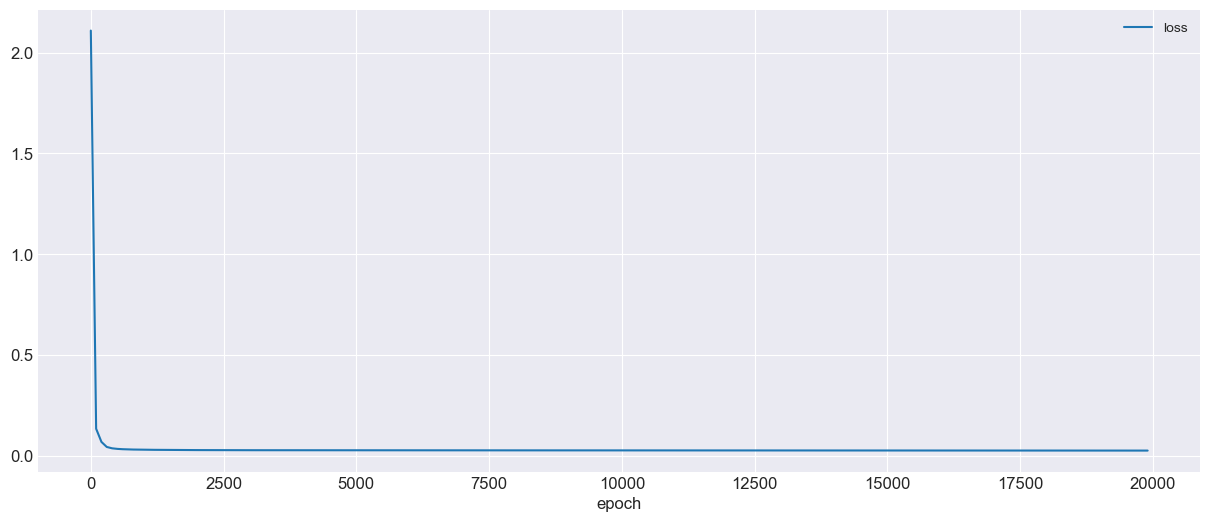

In [70]:
pd.DataFrame(loss_hist).plot(x='epoch', y='loss')

In [71]:
y_pred = predict(model, X_train)

accuracy_score(y_pred=y_pred, y_true=y_train)

0.9825

In [72]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_train)
cm

array([[393,   7],
       [  7, 393]], dtype=int64)

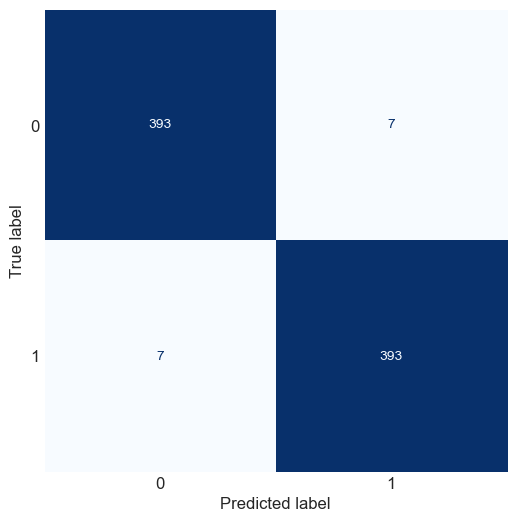

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

0.965


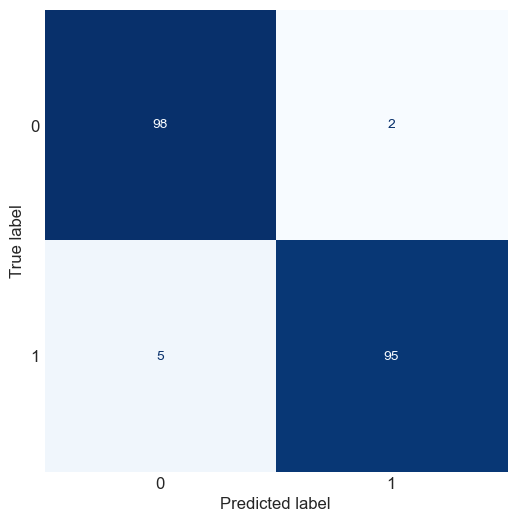

In [74]:
y_pred = predict(model, X_test)
#  calculate accuracy  
print(accuracy_score(y_pred=y_pred, y_true=y_test))

# calculate confusion matrix
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

#plots always look good
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues', colorbar=False)
plt.grid()
plt.show()

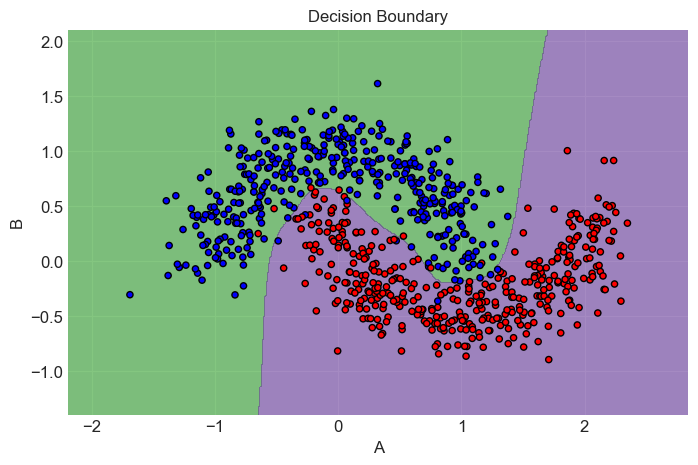

In [75]:
fn_plot_decision_boundary(lambda x:predict(model, x), X_train, y_train)